# Implementation of the squeezed laser

In [1567]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [1568]:
def make_rho(N,ket,bra):
    return tensor(identity(N),ket*bra.dag())

In [1569]:
def H_def(N,a,g,e,r_ket,s_ket,delta_c,Delta_1,Delta_s,Delta_r,g_s,g_r,Omega_s,Omega_r,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    H_cav = delta_c*a.dag()*a+Delta_1*make_rho(N,e,e)+Delta_r*make_rho(N,r_ket,r_ket)+Delta_s*make_rho(N,s_ket,s_ket)
    H_int = np.conj(g_s)*a.dag()*make_rho(N,e,s_ket)+g_s*a*make_rho(N,s_ket,e)+np.conj(g_r)*a.dag()*make_rho(N,g,r_ket)+g_r*a*make_rho(N,r_ket,g)
    H_dr = (Omega_s/2)*(make_rho(N,g,s_ket)+make_rho(N,s_ket,g))+(Omega_r/2)*(make_rho(N,e,r_ket)+make_rho(N,r_ket,e))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))
    return H_cav+H_int+H_dr

In [1570]:
def H_eff(N,a,g,e,g_0,r,theta,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return g_0*(make_rho(N,g,e)*(np.cosh(r)*a.dag()+np.exp(1j*theta)*np.sinh(r)*a)+make_rho(N,e,g)*(np.cosh(r)*a+np.exp(-1j*theta)*np.sinh(r)*a.dag()))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))

In [1571]:
def Lops_def(N,a,g,e,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*make_rho(N,e,g),np.sqrt(k*(1+eta))*a]

#### Parameters

In [1572]:
### General parameters ###

N = 20 # Dimension of the Hilbert space of the cavity
n_q = 20 # Photon saturation number
C = 1.6 # Cooperativity

### Hamiltonian parameters ###

g_0 = 10**(-5) # Light-matter coupling
Delta = 1 # Detunings Delta_s = Delta_r
r = 0.75 # Squeezing parameter
theta = np.pi # Squeezing angle
Omega_r = 1e-2


In [1573]:
Omega_s = np.tanh(r)*Omega_r
delta_c = (4*g_0**2*np.cosh(r)**2*Delta)/Omega_r**2
Delta_1 = (Omega_r**2/(4*Delta))*(1-np.tanh(r)**2)
g_r = -2*Delta*g_0*np.cosh(r)/Omega_r
g_s = g_r*np.exp(1j*theta)

In [1574]:
print(Delta,Omega_s,Omega_r,delta_c,Delta_1,g_r,g_s)

1 0.006351489523872873 0.01 6.704819230486496e-06 1.4914645207033286e-05 -0.0025893665693536897 (0.0025893665693536897-3.171059480978159e-19j)


#### Operators

In [1575]:
a = tensor(destroy(N),identity(4)) # Annihilation operator
g = basis(4,0) # Atomic states
e = basis(4,1)
s_ket = basis (4,2)
r_ket = basis(4,3)

In [1576]:
a_eff = tensor(destroy(N),identity(2))
g_eff = basis(2,0)
e_eff = basis(2,1)

#### Hamiltonian

In [1577]:
H = H_def(N,a,g,e,r_ket,s_ket,delta_c,Delta_1,Delta,Delta,g_s,g_r,Omega_s,Omega_r) # Iniatilize the hamiltonian for the chosen parameters

In [1578]:
Heff = H_eff(N,a_eff,g_eff,e_eff,g_0,r,theta)

In [1579]:
pob_0 = make_rho(N,g,g)
pob_1 = make_rho(N,e,e)
pob_r = make_rho(N,r_ket,r_ket)
pob_s = make_rho(N,s_ket,s_ket)

In [1580]:
pob_0_eff = make_rho(N,g_eff,g_eff)
pob_1_eff = make_rho(N,e_eff,e_eff)

In [1581]:
S = (0.5*(r*np.exp(-1j*theta)*a*a-np.conj(r*np.exp(-1j*theta))*a.dag()*a.dag())).expm() # Squeezing operator
S_eff = (0.5*(r*np.exp(-1j*theta)*a_eff*a_eff-np.conj(r*np.exp(-1j*theta))*a_eff.dag()*a_eff.dag())).expm() # Squeezing operator

In [1600]:
psi_0 = S*tensor(basis(N),e)
psi_0_eff = S_eff*tensor(basis(N),e_eff)
t_vec = np.logspace(np.log10(1e-4),np.log10(1000000000000),10000)

In [1583]:
expect(a.dag()*a,psi_0*psi_0.dag())

0.6761321041153965

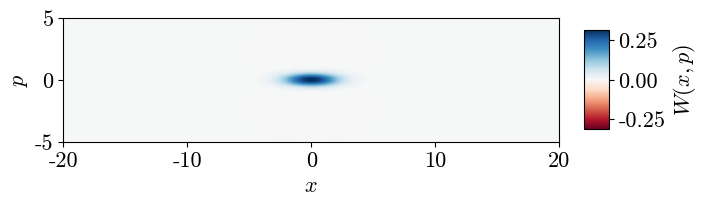

In [1584]:
wr = wigner_rep(rhos = psi_0*psi_0.dag()) # Initialize the calculation with its parameters
x_lim = 20 # X-Axis limits
p_lim = 5 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

In [1585]:
a_s = a*np.cosh(r)+np.exp(-1j*theta)*a.dag()*np.sinh(r) # Annihilation operator of the squeezed basis

In [1586]:
a_s_eff = a_eff*np.cosh(r)+np.exp(-1j*theta)*a_eff.dag()*np.sinh(r) # Annihilation operator of the squeezed basis

#### Introduction of dissipation

In [1662]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
gamma = 0

In [1663]:
(4*g_0**2)/(k*P)

1.6

In [1664]:
L = liouvillian(H,[np.sqrt(k)*a,np.sqrt(P)*make_rho(N,e,g),np.sqrt(gamma)*make_rho(N,e,s_ket)])
L_eff = liouvillian(Heff,[np.sqrt(k)*a_eff,np.sqrt(P)*make_rho(N,e_eff,g_eff)])

In [1665]:
eigval, eigvec_r = L.eigenstates()

In [1666]:
V_r = np.column_stack([ev.full().flatten() for ev in eigvec_r])  # Left and right eigenvectors
V_l = np.transpose(scipy.linalg.inv(V_r))
rho_0 = operator_to_vector(psi_0*psi_0.dag()) # Vectorized initial state

In [1667]:
eigval_eff, eigvec_r_eff = L_eff.eigenstates()

In [1668]:
V_r_eff = np.column_stack([ev.full().flatten() for ev in eigvec_r_eff])  # Left and right eigenvectors
V_l_eff = np.transpose(scipy.linalg.inv(V_r_eff))
rho_0_eff = operator_to_vector(psi_0_eff*psi_0_eff.dag()) # Vectorized initial state

In [1669]:
sorted_ev = np.sort(np.real(eigval))
gap = sorted_ev[-1]-sorted_ev[-2]

In [1670]:
1/gap

393114775.4410138

In [1671]:
1/k

399999.99999999994

In [1672]:
def evolve_rho(t_vec,eigval,V_r,V_l,rho_0):
    aux = np.zeros(np.size(eigval),dtype=complex)

    for i in range(np.size(eigval)):
        aux[i] = np.transpose(V_l[:,i])*rho_0

    aux_2 = np.exp(np.outer(t_vec,eigval))*aux

    return np.tensordot(aux_2,V_r, axes=([1], [1]))


In [1673]:
rho = evolve_rho(t_vec,eigval,V_r,V_l,rho_0)
rho_eff = evolve_rho(t_vec,eigval_eff,V_r_eff,V_l_eff,rho_0_eff)

In [1674]:
p0 = operator_to_vector(pob_0).full().flatten()
p1 = operator_to_vector(pob_1).full().flatten()
pr = operator_to_vector(pob_r).full().flatten()
ps = operator_to_vector(pob_s).full().flatten()

In [1675]:
p0_eff = operator_to_vector(pob_0_eff).full().flatten()
p1_eff = operator_to_vector(pob_1_eff).full().flatten()

In [1676]:
n = operator_to_vector(a.dag()*a).full().flatten()
n_eff = operator_to_vector(a_eff.dag()*a_eff).full().flatten()

In [1677]:
p0_exp = []
p1_exp = []
pr_exp = []
ps_exp = []
n_exp = []

for j in tqdm(range(np.size(t_vec))):
    p0_exp.append(np.matmul(p0,rho[j]))
    p1_exp.append(np.matmul(p1,rho[j]))
    pr_exp.append(np.matmul(pr,rho[j]))
    ps_exp.append(np.matmul(ps,rho[j]))
    n_exp.append(np.matmul(n,rho[j]))

100%|██████████| 10000/10000 [00:00<00:00, 22444.17it/s]


In [1678]:
p0_exp_eff = []
p1_exp_eff = []
n_exp_eff = []

for j in tqdm(range(np.size(t_vec))):
    p0_exp_eff.append(np.matmul(p0_eff,rho_eff[j]))
    p1_exp_eff.append(np.matmul(p1_eff,rho_eff[j]))
    n_exp_eff.append(np.matmul(n_eff,rho_eff[j]))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 57812.44it/s]


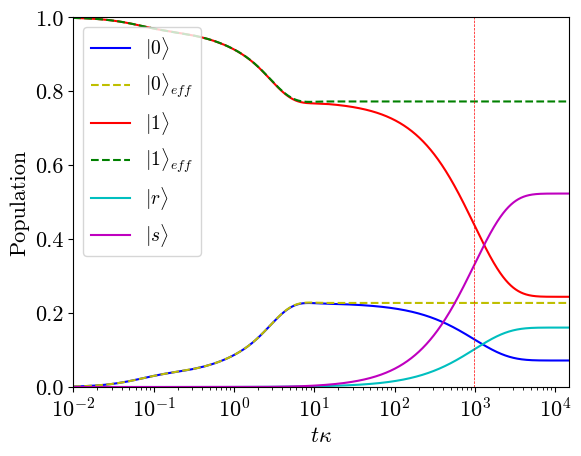

In [1679]:
fig, ax = plt.subplots()
ax.plot(t_vec*k,p0_exp,'b',label=r'$|0\rangle$')
ax.plot(t_vec*k,p0_exp_eff,'y--',label=r'$|0\rangle_{eff}$')
ax.plot(t_vec*k,p1_exp,'r',label=r'$|1\rangle$')
ax.plot(t_vec*k,p1_exp_eff,'g--',label=r'$|1\rangle_{eff}$')
ax.plot(t_vec*k,pr_exp,'c',label=r'$|r\rangle$')
ax.plot(t_vec*k,ps_exp,'m',label=r'$|s\rangle$')
#ax.plot(t_vec*k,n_exp,'k',label=r'$n$')
#ax.plot(t_vec*k,n_exp_eff,'--',color='lightgrey',label=r'$n_{eff}$')
ax.plot([(1/gap-1e-15)*k,(1/gap+1e-15)*k],[-10,10],'r--',lw=0.5)
plt.legend(fontsize = 14, loc=2)
plt.xlabel('$t\kappa$')
plt.ylabel('Population')
plt.ylim([0,1])
#plt.ylim([0.99,1.0001])
plt.xlim([1e-2,15000])
plt.xscale('log')
fig.savefig('./4LS\PREVIA_4_2.png',dpi=500, bbox_inches = 'tight')

In [1680]:
check = Qobj(rho[-1].reshape((N*4,N*4), order='F'), dims=[[N,4],[N,4]])

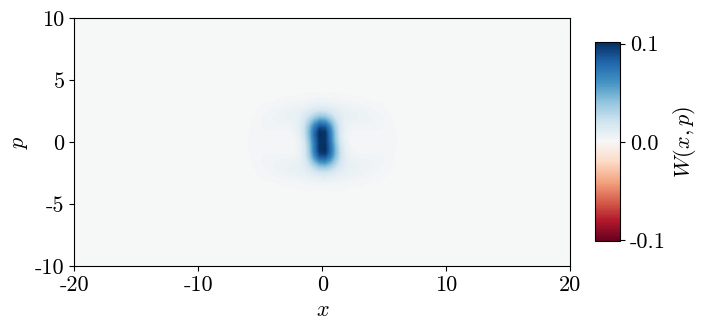

In [1682]:
wr = wigner_rep(rhos = check) # Initialize the calculation with its parameters
x_lim = 20 # X-Axis limits
p_lim = 10 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function